# Use Apache SystemML and Spark for machine learning

This notebook introduces Apache SystemML and shows examples of running different forms of Linear Regression (Direct Solve, Batch Gradient Descent and Conjugate Gradient).  The code snippets are adapted from Apache SystemML __<a href="http://systemml.apache.org/get-started" target="_blank" rel="noopener noreferrer">sample notebooks</a>__ and run on Python 2 with Spark 2.1.  Some familiarity with Python and machine learning algorithms is recommended.


## Table of Contents

- [Apache SystemML](#systemml)<br>
- [Matrix multiplication](#matrix-multiply)<br>
- [Linear regression direct solve](#direct-solve)<br>
- [Linear regression "out-of-the-box"](#linear-regression)<br>
- [Linear regression batch gradient descent](#gradient-descent)<br>
- [Linear regression conjugate gradient](#conjugate-gradient)<br>
- [Linear regression using mllearn interface](#linear-regression-api)<br>
- [Learn more](#summary)

<a id="systemml"></a>
## Apache SystemML

#### Machine learning library for scalable distributable solution 
Apache SystemML provides an optimal workplace for machine learning using big data. It can be run on top of Apache Spark, where it automatically scales your data, line by line, determining whether your code should be run on the driver or an Apache Spark cluster. Future SystemML developments include additional deep learning with GPU capabilities such as importing and running neural network architectures and pre-trained models for training.

It contains many popular machine learning algorithms (e.g., regression, clustering, classification, descriptive statistics) that can be used out-of-the-box or customized if necessary.  Algorithms are written in Python-like or R-like scripting languages intuitive to a Data Scientist familiar with Python or R.  Higher-level abstractions that encapsulate well-known algorithms are also provided for a Data Scientist to get started without needing to know the script implementation details.

#### Machine learning development challenges
Typically a Data Scientist writes and evaluates a machine learning algorithm with small data on a single machine. To apply the algorithm to big data in a clustered environment often requires an experienced Systems Engineer familiar with distributed programming.  However, an algorithm migrated to run on a large scale environment may not produce the same expected results due to problems in original algorithm or errors in converting the algorithm to run on a cluster.   Revising the algorithm ends up being an error-prone, time-consuming process since the Systems Engineer doesn't have expertise with the algorithm and the Data Scientist isn't familiar with distributed programming.

#### Apache SystemML to the rescue
Apache SystemML eliminates these algorithm development issues since it creates an optimized program that adapts to data characteristics.  A Data Scientist can focus on algorithm development and let Apache SystemML distribute processing as needed when that same algorithm is run with bigger data on larger environment.

#### Ease of use
Apache SystemML functionality can be accessed from Python, Scala and Java application programming interfaces.  Batch processing (e.g., spark-submit) is also supported.  Note Apache SystemML is a pre-installed library and available in Data Science Experience with Spark so no separate installation is required.  For example, use pip to show available version.

In [1]:
!pip show systemml

Name: systemml
Version: 0.14.0
Summary: Apache SystemML is a distributed and declarative machine learning platform.
Home-page: http://systemml.apache.org/
Author: Apache SystemML
Author-email: dev@systemml.incubator.apache.org
License: Apache 2.0
Location: /usr/local/src/analytic-libs/spark-2.0/python-2.7
Requires: numpy, pandas, scipy


<a id="matrix-multiply"></a>
## Matrix multiplication

In Linear Algebra operations including operands of type Matrix or Vector, its critical from performance perspective to do operation on group of numbers simultaneously. So Matrix (or Vector) operations play a key role in Linear Algebra performance. There are multiple libraries available for Matrix operations.

Apache SystemML contains many __<a href="http://apache.github.io/systemml/dml-language-reference.html#built-in-functions" target="_blank" rel="noopener noreferrer">built-in functions</a>__ for handling linear algebra operations.  Here's a simple example showing how to create a script that generates a random matrix, multiplies the matrix with its transpose, and computes the sum of the output.  

#### Matrix multiplication using Numpy of matrix size (1M x 1K)
Following code snippet shows numpy used to do matrix multiplication of transpose of matrix to itself of matrix size (1M x 1K). As data can fit into memory, you get a result.

In [2]:
import numpy as np

a = np.random.rand(10**6, 1000)
transMult = np.matmul(a.transpose(),a)
sum = np.sum(transMult)
print (sum)

250084077924.0


#### Matrix multiplication using Numpy of matrix size (10M x 1K)
Following code snippet shows numpy used to do matrix multiplication of transpose of matrix to itself of matrix size (10M x 1K). As data cannot fit into memory, operation gives an error.

In [3]:
import numpy as np

a = np.random.rand(10**7, 1000)
transMult = np.matmul(a.transpose(),a)
sum = np.sum(transMult)
print (sum)

MemoryError: 

#### Matrix multiplication using Apache SystemML of matrix size (10M x 1K)
Following code snippet shows matrix multiplication of transpose of matrix to itself of matrix size (10M x 1K). Apache SystemML does not depend just on local memory but it leverages cluster environment to do any operation. An operation with same data size which cannot be run using Numpy can be done using Apache SystemML as it performs operations in distributed environment if data cannot fit onto local memory. It also demonstrates use of Apache SystemML's __<a href="http://apache.github.io/systemml/spark-mlcontext-programming-guide" target="_blank" rel="noopener noreferrer">MLContext Application Programming Interface (API)</a>__ to execute the program.

In [4]:
from systemml import MLContext, dml

ml = MLContext(sc)

script = """
    X = rand(rows=$nr, cols=1000, sparsity=1.0)
    A = t(X) %*% X
    s = sum(A)
"""

prog = dml(script).input('$nr', 10**7).output('s')
s = ml.execute(prog).get('s')
print(s)

2.50084267337e+12


<a id="linear-regression"></a>
## Data generation

Lets generate some synthetic data through script specified below and run through Apache SystemML. 
We will use same data for all use cases described in the notebook below.

In [5]:
from systemml import MLContext, dml

ml = MLContext(sc)

script = """
    numSamples = $numSamples
    numFeatures = $numFeatures
    sparsity = 0.5
    maxFeatureValue = 15
    maxWeight = 25
    addNoise = 100
    fmt = "csv"
    trainTestRatio = 0.7
    trainSize = trainTestRatio * numSamples
    testSize = numSamples - trainSize

    X = Rand(rows=numSamples, cols=numFeatures, min=-1, max=1, pdf="uniform", seed=0, sparsity=sparsity)
    w = Rand(rows=numFeatures, cols=1, min=-1, max=1, pdf="uniform", seed=0)
    X = X * maxFeatureValue
    w = w * maxWeight
    Y = X %*% w

    noise = Rand(rows=numSamples, cols=1, pdf="normal", seed=0)
    Y = Y + addNoise*noise
    
    X_train = X[1:trainSize,]
    X_test = X[trainSize+1:numSamples,]
    y_train = Y[1:trainSize,]
    y_test = Y[trainSize+1:numSamples,]
"""

prog = dml(script).input('$numSamples', 10**6).input('$numFeatures', 10).output('X_train').output('y_train').output('X_test').output('y_test')
X_train_m, y_train_m, X_test_m, y_test_m = ml.execute(prog).get('X_train','y_train','X_test','y_test')
X_train = X_train_m.toNumPy()
y_train = y_train_m.toNumPy()
X_test = X_test_m.toNumPy()
y_test = y_test_m.toNumPy()

<a id="direct-solve"></a>
## Linear regression direct solve

This algorithm computes the least squares solution for system of linear equations A %*% w = b i.e., it finds w such that ||A%*%w – b|| is minimized, where A = X'X and b= X'y

### Least squares formulation
w* = argminw ||Xw-y||2 = argminw (y - Xw)'(y - Xw) = argminw (w'(X'X)w - w'(X'y))/2

### Setting the gradient
dw = (X'X)w - (X'y) to 0, w = (X'X)-1(X' y) = solve(X'X, X'y)

The following cell creates and runs a script using Apache SystemML that generates a small Spark job for distributed data processing.

In [6]:
from systemml import MLContext, dml

ml = MLContext(sc)

script = """
    # add constant feature to X to model intercept
    X = cbind(X, matrix(1, rows=nrow(X), cols=1))
    A = t(X) %*% X
    b = t(X) %*% y
    w = solve(A, b)
    bias = as.scalar(w[nrow(w),1])
    w = w[1:nrow(w)-1,]
"""

prog = dml(script).input(X=X_train, y=y_train).output('w', 'bias')
w, bias = ml.execute(prog).get('w','bias')
w = w.toNumPy()

Display the results with matplotlib.

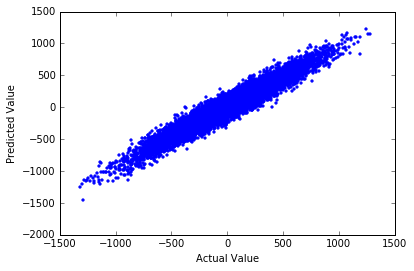

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

chosen_idx = np.random.choice(300000, replace=False, size=10000)
plt.scatter(y_test[chosen_idx], np.matmul(X_test[chosen_idx],w)+bias,  color='blue', marker='.')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')

<a id="linear-regression"></a>
## Linear regression "out-of-the-box"

Apache SystemML has a large selection of __<a href="https://apache.github.io/systemml/algorithms-reference.html" target="_blank" rel="noopener noreferrer">algorithm implementations</a>__ that can be used without modifications.  For this example, an existing algorithm will be loaded and executed. 

In [8]:
from systemml import MLContext, dml, dmlFromResource

ml = MLContext(sc)

dml_script = dmlFromResource("/scripts/algorithms/LinearRegDS.dml")

prog = dml_script.input(X=X_train, y=y_train).input('$icpt',1.0).output('beta_out')
w = ml.execute(prog).get('beta_out')
w = w.toNumPy()

bias = w[w.shape[0]-1]
w = w[:w.shape[0]-1]

print(bias)

[ 0.00644517]


The results can be displayed graphically using matplotlib as shown below.

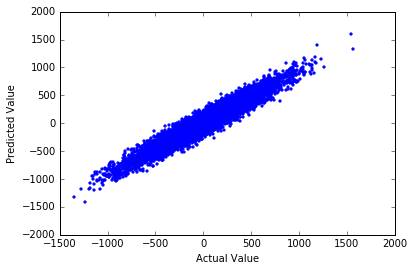

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

chosen_idx = np.random.choice(300000, replace=False, size=10000)
plt.scatter(y_test[chosen_idx], np.matmul(X_test[chosen_idx],w)+bias,  color='blue', marker='.')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')

<a id="gradient-descent"></a>
## Linear regression batch gradient descent

Gradient descent is a first-order iterative optimization algorithm for finding the minimum of a function. To find a local minimum of a function using gradient descent, one takes steps proportional to the negative of the gradient (or of the approximate gradient) of the function at the current point.

#### Algorithm
`Step 1: Start with an initial point 
while(not converged) { 
  Step 2: Compute gradient dw. 
  Step 3: Compute stepsize alpha.     
  Step 4: Update: wnew = wold + alpha*dw 
}`

#### Gradient formula
`dw = r = (X'X)w - (X'y)`

#### Step size formula
`Find number alpha to minimize f(w + alpha*r) 
alpha = -(r'r)/(r'X'Xr)`


Create and execute an Apache SystemML script that uses Spark to distribute data processing.

In [10]:
from systemml import MLContext, dml

ml = MLContext(sc)

script = """
    # add constant feature to X to model intercepts
    X = cbind(X, matrix(1, rows=nrow(X), cols=1))
    max_iter = 100
    w = matrix(0, rows=ncol(X), cols=1)
    for(i in 1:max_iter){
        XtX = t(X) %*% X
        dw = XtX %*%w - t(X) %*% y
        alpha = -(t(dw) %*% dw) / (t(dw) %*% XtX %*% dw)
        w = w + dw*alpha
    }
    bias = as.scalar(w[nrow(w),1])
    w = w[1:nrow(w)-1,]    
"""

prog = dml(script).input(X=X_train, y=y_train).output('w').output('bias')
w, bias = ml.execute(prog).get('w', 'bias')
w = w.toNumPy()


Visualize the results with matplotlib.

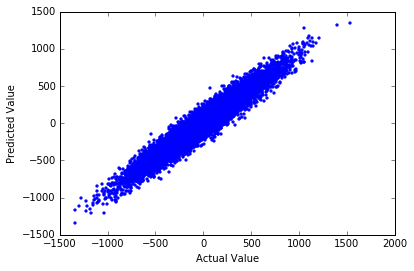

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

chosen_idx = np.random.choice(300000, replace=False, size=10000)
plt.scatter(y_test[chosen_idx], np.matmul(X_test[chosen_idx],w)+bias,  color='blue', marker='.')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')

<a id="conjugate-gradient"></a>
## Linear regression conjugate gradient

A problem with gradient descent is that it takes very similar directions many times.  Modifying the original gradient descent algorithm with an additional step to enforcing conjugacy resolves this issue.

`Step 1: Start with an initial point 
while(not converged) {
   Step 2: Compute gradient dw.
   Step 3: Compute stepsize alpha.
   Step 4: Compute next direction p by enforcing conjugacy with previous direction.
   Step 5: Update: w_new = w_old + alpha*p
}`


Define the algorithm in Apache SystemML's scripting language and execute the corresponding program using __<a href="http://apache.github.io/systemml/spark-mlcontext-programming-guide" target="_blank" rel="noopener noreferrer">MLContext Application Programming Interface (API)</a>__.

In [12]:
from systemml import MLContext, dml

ml = MLContext(sc)

script = """
    # add constant feature to X to model intercepts
    X = cbind(X, matrix(1, rows=nrow(X), cols=1))
    m = ncol(X); i = 1; 
    max_iter = 20;
    w = matrix (0, rows = m, cols = 1); # initialize weights to 0
    dw = - t(X) %*% y; p = - dw;        # dw = (X'X)w - (X'y)
    norm_r2 = sum (dw ^ 2); 
    for(i in 1:max_iter) {
        q = t(X) %*% (X %*% p)
        alpha = norm_r2 / sum (p * q);  # Minimizes f(w - alpha*r)
        w = w + alpha * p;              # update weights
        dw = dw + alpha * q;           
        old_norm_r2 = norm_r2; norm_r2 = sum (dw ^ 2);
        p = -dw + (norm_r2 / old_norm_r2) * p; # next direction - conjugacy to previous direction
        i = i + 1;
    }
    bias = as.scalar(w[nrow(w),1])
    w = w[1:nrow(w)-1,]    
"""

prog = dml(script).input(X=X_train, y=y_train).output('w').output('bias')
w, bias = ml.execute(prog).get('w','bias')
w = w.toNumPy()


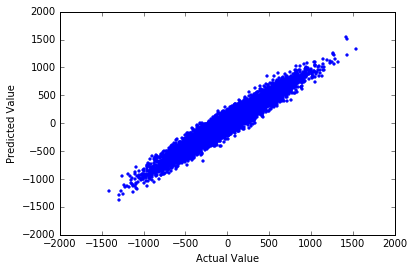

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

chosen_idx = np.random.choice(300000, replace=False, size=10000)
plt.scatter(y_test[chosen_idx], np.matmul(X_test[chosen_idx],w)+bias,  color='blue', marker='.')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')

<a id="linear-regression-api"></a>
## Linear regression using mllearn interface

Python developers can use the __<a href="https://apache.github.io/systemml/python-reference#mllearn-api" target="_blank" rel="noopener noreferrer">mllearn interface</a>__ from Apache SystemML to invoke algorithms with scikit-learn. You will notice that this mllearn interface from Apache SystemML is similar to scikit-learn interface.

The next cell runs __<a href="https://apache.github.io/systemml/algorithms-regression.html#linear-regression" target="_blank" rel="noopener noreferrer">Linear Regression</a>__ against the sample data taking approximately sixteen Spark jobs to complete processing.  Since the number of features in the sample dataset is small, Linear Regression Direct Solve is used with `solver='direct-solve'`.  To switch to Linear Regression Conjugate Gradient, specify `solver='newton-cg'`.

### Apache SystemML code to do linear regression using mllearn interface

In [14]:
from systemml.mllearn import LinearRegression

# Create Linear Regression object through sklearn
regr = LinearRegression(spark, solver='direct-solve', transferUsingDF=True)

# Train the model using the training sets through sklearn
regr.fit(X_train, y_train)

# Make predictions using the testing set through sklearn
mllearn_predicted = regr.predict(X_test)

Utilities from sklearn can be used to (R^2) score the results as shown below.

In [15]:
from sklearn import linear_model
from sklearn.metrics import r2_score

# Create Linear Regression object through scikit-learn
sklearn_regr = linear_model.LinearRegression()

# Train the model using the training sets through scikit-learn
sklearn_regr.fit(X_train, y_train)

# Make predictions using the testing set through scikit-learn
sklearn_predicted = sklearn_regr.predict(X_test)

# Calculate R^2 score  using sklearn by passing predictions obtained through mllearn and scikit-learn
score = r2_score(sklearn_predicted, mllearn_predicted)
print('Linear Regression score: %f' % score)

Linear Regression score: 1.000000


<a id="summary"></a>
## Learn more

Visit __<a href="http://systemml.apache.org/" target="_blank" rel="noopener noreferrer">Apache SystemML</a>__ for additional examples and documentation.  For questions or requests for more information, please use the __<a href="http://apache.github.io/systemml/contributing-to-systemml#development-mailing-list" target="_blank" rel="noopener noreferrer">development mailing list</a>__.  To get involved, see __<a href="http://apache.github.io/systemml/contributing-to-systemml" target="_blank" rel="noopener noreferrer">contributing to Apache SystemML</a>__ for details.

<a id="authors"></a>
### Authors

This notebook is built upon __<a href="https://github.com/apache/systemml/graphs/contributors" target="_blank" rel="noopener noreferrer">contributions from developers</a>__ of Apache SystemML.  **Arvind Surve** is an architect at IBM in San Jose, California.  He has been an active committer for Apache SystemML since it was initially contributed to open source and has written a __<a href="http://www.spark.tc/tutorial-declarative-ml/" target="_blank" rel="noopener noreferrer">Declarative Machine Learning Tutorial</a>__ with Apache SystemML.  **Glenn Weidner** is a software developer at IBM in San Francisco, California.  He's a member of the __<a href="http://www.spark.tc/" target="_blank" rel="noopener noreferrer">Spark Technology Center</a>__ and also a committer for Apache SystemML.

<hr>
Copyright &copy; IBM Corp. 2017. This notebook and its source code are released under the terms of the MIT License.